## Dynamic Topic Modelling

NMF vs. LDA vs. LSA

LDA is based on probabilistic graphical modeling while NMF and LSA rely on linear algebra.

The aim of LDA and NMF algorithm is then to produce 2 smaller matrices; a document to topic matrix and a word to topic matrix that when multiplied together reproduce the bag of words/tfidf matrix with the lowest error. LSA has an extra topic to topic diagonal matrix. 


In [17]:
from datetime import datetime
import pandas as pd
import numpy as np
import json
import re
import string
import nltk
import matplotlib.pyplot as plt

In [18]:
df = pd.read_csv("timeseries_data.csv")
df.head()

,Unnamed: 0,filingDate,reportingDate,financialEntity,coDescription,CIK,coDescription_lemmatized,coDescription_stopwords,reports
0,0,2017-06-29 20:05:22 UTC,2017-04-01,financialEntities/params;cik=1164888,m2.properties 4 item3.legalproceedings 4 ite...,1164888,m2.properties 4 item3.legalproceedings 4 item4...,disclosure part iiitem marketfor registrant co...,3
1,1,2016-03-03 17:53:54 UTC,2016-02-01,financialEntities/params;cik=1637459,l kraft heinz is one of the largest food and b...,1637459,l kraft heinz is one of the largest food and b...,l kraft heinz one largest food beverage compan...,3
2,2,2018-05-25 01:55:42 UTC,2018-04-01,financialEntities/params;cik=1302215,"established in 1972, houlihan lokey, inc., is ...",1302215,"established in 1972 , houlihan lokey , inc. , ...",established houlihan lokey leading global inde...,3
3,3,2018-12-19 22:01:54 UTC,2018-10-01,financialEntities/params;cik=725363,solved seccomments none item2.properties cel-s...,725363,solved seccomments none item2.properties cel-s...,solved seccomments none office space boone blv...,3
4,4,2018-02-28 18:47:50 UTC,2018-01-01,financialEntities/params;cik=103379,"orporation, organized in 1899, is a global lea...",103379,"orporation , organized in 1899 , is a global l...",orporation organized global leader design prod...,3


In [102]:
filtered = df[df["reports"] == 3].sort_values(["CIK","filingDate"])
filtered

,Unnamed: 0,filingDate,reportingDate,financialEntity,coDescription,CIK,coDescription_lemmatized,coDescription_stopwords,reports
1948,1948,2016-12-06 22:05:12 UTC,2016-10-01,financialEntities/params;cik=3545,"alico, inc. (“alico”), was incorporated under ...",3545,"alico , inc. ( “ alico ” ) , wa incorporated u...",alico alico wa incorporated law state florida ...,3
1456,1456,2017-12-11 22:13:06 UTC,2017-10-01,financialEntities/params;cik=3545,"alico, inc. (“alico”) was incorporated under t...",3545,"alico , inc. ( “ alico ” ) wa incorporated und...",alico alico wa incorporated law state florida ...,3
83,83,2018-12-06 21:58:38 UTC,2018-10-01,financialEntities/params;cik=3545,"alico, inc. (“alico”) was incorporated under t...",3545,"alico , inc. ( “ alico ” ) wa incorporated und...",alico alico wa incorporated law state florida ...,3
832,832,2016-05-25 20:19:47 UTC,2016-04-01,financialEntities/params;cik=4457,we are north america’s largest “do-it-yourself...,4457,we are north america ’ s largest “ do-it-yours...,north america largest moving storage operator ...,3
1242,1242,2017-05-24 20:07:02 UTC,2017-04-01,financialEntities/params;cik=4457,we are north america’s largest “do-it-yourself...,4457,we are north america ’ s largest “ do-it-yours...,north america largest moving storage operator ...,3
...,...,...,...,...,...,...,...,...,...
1531,1531,2017-11-29 02:25:15 UTC,2017-10-01,financialEntities/params;cik=1666138,llowing discussion of our business contains fo...,1666138,llowing discussion of our business contains fo...,llowing discussion business contains statement...,3
481,481,2018-11-28 01:38:36 UTC,2018-10-01,financialEntities/params;cik=1666138,llowing discussion of our business contains fo...,1666138,llowing discussion of our business contains fo...,llowing discussion business contains statement...,3
963,963,2016-12-19 14:14:40 UTC,2016-10-01,financialEntities/params;cik=1674910,generalvalvoline inc. is a kentucky corporatio...,1674910,generalvalvoline inc. is a kentucky corporatio...,generalvalvoline kentucky corporation principa...,3
1760,1760,2017-11-17 17:10:16 UTC,2017-10-01,financialEntities/params;cik=1674910,"generalvalvoline inc., a kentucky corporation,...",1674910,"generalvalvoline inc. , a kentucky corporation...",generalvalvoline kentucky corporation worldwid...,3


In [107]:
ticker = pd.read_csv("cik_ticker.csv")
sic = pd.read_csv("sic_naics.csv")
filtered = filtered.join(ticker.set_index("CIK"), on = "CIK", how = "left").join(sic.set_index("SIC"), on = "SIC", how="left")
filtered["SIC_Descrip"] = filtered["SIC_Descrip"].fillna("")
filtered["SIC"] = (filtered["SIC"]//100)*100

In [108]:
data = filtered.loc[:,"coDescription_stopwords"].to_list()
dates = filtered["filingDate"].to_list()

In [121]:
## Dynamic Topic Modelling with Netflix, GE
targetComp = pd.read_csv("dynamic_companies.csv")
netflix = targetComp[targetComp["financialEntity"] == "financialEntities/params;cik=1065280"].sort_values(["filingDate"])
ge = targetComp[targetComp["financialEntity"] == "financialEntities/params;cik=40545"].sort_values(["filingDate"])

## NMF

### Evaluate Best Number of Topics - Coherence Score

Coherence score measures the relative distance between words within a topic.  
- CV coherence score creates content vectors of words using their co-occurrences (ie. co-occurence of "Las" and "Vegas" would be very high) and, after that, calculates the score using normalized pointwise mutual information (NPMI). NPMI is the likelihood of the co-occurrence of two words, taking into account the fact that it might be caused by the frequency of the single words. 

$NPMI(a,b) = \frac{log\frac{P(a,b)+\epsilon}{P(a)P(b)}}{-log(P(a,b)+\epsilon)}$

Probabilities of single words p(a) or the joint probability of two words p(a,b) can be estimated by Boolean document calculation, that is, the number of documents in which (a) or (a,b) occurs, divided by the total number of documents.

We calculate the global coherence of the topic as the average pairwise coherence scores on the top N words which describe the topic.

In [119]:
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, TfidfModel
from gensim.models.basemodel import BaseTopicModel
from gensim.models.nmf import Nmf 

dictionary = Dictionary(doc.split() for doc in data)
 # filter out too in/frequent tokens
dictionary.filter_extremes(no_below=0.01, no_above=0.85, keep_n = 5000)

corpus = [dictionary.doc2bow(doc.split()) for doc in data]
# create list of topic number we want to try 
topic_nums = list(np.arange(3, 40,3))

coherence_scores = []
for num in topic_nums:
    nmf = Nmf(corpus=corpus,
    num_topics=num,
    id2word=dictionary,
    passes=5,
    eval_every=10,
    minimum_probability=0.01,
    random_state=0,
    kappa=.1,
    normalize=True)
    
    
    cm = CoherenceModel(
    model=nmf,
    texts=[doc.split() for doc in data],
    dictionary=dictionary,
    coherence="c_v")

    coherence_scores.append(round(cm.get_coherence(),5))

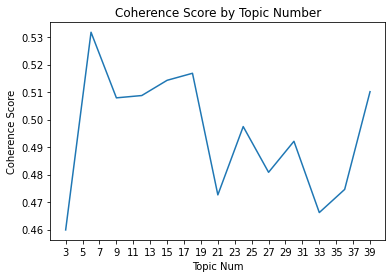

In [118]:
import matplotlib.pyplot as plt
scores = list(zip(topic_nums, coherence_scores))
plt.plot(topic_nums, coherence_scores)
plt.xticks(np.arange(3, 40,2))
plt.ylabel('Coherence Score')
plt.xlabel('Topic Num')
plt.title("Coherence Score by Topic Number")
plt.show()

In [161]:
def get_topics(model, num_topics):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [135]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
        
vectorizer = TfidfVectorizer(max_df=0.85, max_features=2000) 
X = vectorizer.fit_transform(data)

nmf_model = NMF(n_components=19, init='nndsvd', random_state=0)
nmf_feature = nmf_model.fit_transform(X)
nmf_component =nmf_model.components_

get_topics(nmf_model,19)

C:\Users\maryx\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19
0,customer,store,share,patient,loan,gas,ethanol,software,president,tax,brand,mineral,investment,could,home,item,client,aircraft,cannabis
1,manufacturing,merchandise,stock,clinical,bank,oil,corn,customer,vice,income,food,exploration,fund,customer,land,statement,solution,system,medical
2,technology,customer,common,fda,credit,natural,grain,application,officer,cash,consumer,mining,adviser,adversely,community,registrant,care,aviation,lease
3,material,brand,agreement,trial,institution,drilling,distiller,data,chief,note,segment,gold,portfolio,regulation,construction,part,healthcare,flight,property
4,system,apparel,merger,drug,mortgage,well,fuel,solution,served,net,retail,claim,income,affect,property,stockholder,health,military,colorado
5,semiconductor,retail,shareholder,cancer,borrower,pipeline,gallon,platform,executive,asset,beverage,project,capital,law,mortgage,equity,provider,defense,pharmaceutical
6,segment,fiscal,director,device,deposit,production,plant,user,senior,ended,restaurant,mine,advisor,cost,estate,supplementary,segment,engine,facility
7,equipment,assortment,issued,treatment,lending,reserve,gasoline,cloud,since,loss,ingredient,property,fee,credit,real,discussion,provide,contract,growing
8,industrial,retailer,outstanding,study,estate,crude,renewable,network,director,statement,agreement,permit,security,future,building,disclosure,revenue,government,plant
9,solution,footwear,exchange,therapy,federal,water,energy,mobile,joining,liability,distribution,environmental,equity,change,residential,ii,data,aerospace,warrant


### Clustering

In [143]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px

def visualize_pca(vectors, index):
    multi_index = pd.MultiIndex.from_frame(index, names=["name", "industry"])
    
    pca = PCA(n_components = 20)
    pca_embedding = pca.fit_transform(vectors)
    pca_embedding = pd.DataFrame(pca_embedding, index = multi_index)
    
    fig = px.scatter(pca_embedding, x =0 , y = 1, hover_data={"name": pca_embedding.index.get_level_values(0),
                                                              "industry": pca_embedding.index.get_level_values(1)}, width=1200, height=600)
    fig.show()
    
    return [pca, pca_embedding]

In [68]:
fig = px.scatter_3d(plot_pca[1], x =0 , y = 1, z = 2, hover_data={"name": plot_pca[1].index.get_level_values(0),
                                                              "industry": plot_pca[1].index.get_level_values(1)},
                     width=1200, height=700)
fig.show()

### Difference in document-topic vectors

In [224]:
X = vectorizer.transform(netflix["coDescription"].tolist())
netflix_top = nmf_model.transform(X)
netflix_top_df = pd.DataFrame(netflix_top).set_index(netflix["filingDate"])
netflix_top_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
filingDate,,,,,,,,,,,,,,,,,,,
2008-02-28T00:42:30Z,0.0,0.032646,0.008761,0.003169,0.0,0.000000,0.001068,0.104448,0.000000,0.002305,0.014386,0.000000,0.000886,0.007970,0.089590,0.000656,0.0,0.0,0.003515
2009-02-25T21:22:45Z,0.0,0.020550,0.011477,0.003090,0.0,0.000000,0.000966,0.098338,0.000000,0.003344,0.023978,0.000473,0.000000,0.004525,0.075930,0.006283,0.0,0.0,0.005248
2010-02-22T19:09:32Z,0.0,0.019790,0.005168,0.002333,0.0,0.000000,0.001297,0.105150,0.000000,0.005486,0.036143,0.000000,0.001576,0.008300,0.058254,0.004281,0.0,0.0,0.007246
2011-02-18T19:42:40Z,0.0,0.000000,0.008842,0.002162,0.0,0.000628,0.000218,0.076972,0.005155,0.000000,0.032321,0.006933,0.005011,0.016106,0.035069,0.009916,0.0,0.0,0.002295
2012-02-10T22:29:24Z,0.0,0.000000,0.003774,0.000000,0.0,0.002275,0.001660,0.089243,0.006299,0.016682,0.043401,0.007165,0.000000,0.021560,0.041876,0.029198,0.0,0.0,0.002826


In [149]:
#compare 2012 with 2008 
netflix_top_df.iloc[-1] - netflix_top_df.iloc[0]

0     0.000000
1    -0.032646
2    -0.004987
3    -0.003169
4     0.000000
5     0.002275
6     0.000592
7    -0.015204
8     0.006299
9     0.014377
10    0.029015
11    0.007165
12   -0.000886
13    0.013589
14   -0.047714
15    0.028541
16    0.000000
17    0.000000
18   -0.000689
dtype: float64

In [211]:
netflix_top_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
filingDate,,,,,,,,,,,,,,,,,,,,
2008-02-28T00:42:30Z,0.320044,0.086204,-0.012440,-0.003216,-0.026677,-0.089333,0.096739,0.159221,-0.004736,0.071193,0.044994,-0.012463,-0.074672,-0.118126,0.054081,0.111513,-0.084884,0.018566,-0.083206,-0.026132
2009-02-25T21:22:45Z,0.298948,0.057729,-0.011823,0.004651,-0.036582,-0.081763,0.092373,0.143640,0.000248,0.073183,0.056701,-0.020148,-0.086579,-0.124094,0.051609,0.127711,-0.076010,0.050323,-0.103739,-0.025288
2010-02-22T19:09:32Z,0.311064,0.075021,-0.032046,-0.002118,-0.028246,-0.084266,0.093036,0.134595,-0.001380,0.065354,0.065963,-0.032756,-0.090979,-0.121018,0.026939,0.108635,-0.055247,0.042715,-0.098052,-0.016218
2011-02-18T19:42:40Z,0.235158,0.009781,-0.028781,0.007047,-0.037482,-0.057171,0.063465,0.094612,0.028675,0.047091,0.070260,-0.003777,-0.080929,-0.097285,0.004142,0.129168,-0.046366,0.050336,-0.093099,-0.012742
2012-02-10T22:29:24Z,0.298476,0.011272,-0.029652,-0.010918,-0.043767,-0.058476,0.064649,0.094965,0.017139,0.023829,0.076288,0.002456,-0.122445,-0.125573,0.020715,0.137674,-0.034547,0.038780,-0.104771,0.000587


In [226]:
np.sum(netflix_top_df.iloc[0]**2)

0.020378707908341814

- decrease in topic 2(retail/store), 15(real estate/land)
- increase in topic 10 (finances), 11 (branding?)
- interesting decrease in topic 8(software)

In [150]:
X = vectorizer.transform(ge["coDescription"].tolist())
ge_top = nmf_model.transform(X)
ge_top_df = pd.DataFrame(ge_top).set_index(ge["filingDate"])
ge_top_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
filingDate,,,,,,,,,,,,,,,,,,,
2011-02-25T21:33:50Z,0.017648,0.0,0.000000,0.020960,0.033407,0.069689,0.005367,0.008763,0.003041,0.0,0.031270,0.00292,0.044842,0.000000,0.069361,0.044335,0.012148,0.184788,0.006936
2012-02-24T21:29:18Z,0.022081,0.0,0.001496,0.019734,0.038563,0.094123,0.002172,0.000000,0.001420,0.0,0.025274,0.00000,0.044054,0.000000,0.056504,0.053033,0.017329,0.182349,0.003661
2013-02-26T22:17:59Z,0.022308,0.0,0.006230,0.013948,0.036938,0.097881,0.000000,0.000000,0.000000,0.0,0.026266,0.00000,0.036589,0.000000,0.051409,0.068041,0.015313,0.179075,0.004380
2014-02-27T21:55:58Z,0.026679,0.0,0.001352,0.014102,0.054518,0.089410,0.000000,0.000000,0.001166,0.0,0.033373,0.00000,0.042842,0.000254,0.044664,0.073127,0.017807,0.145104,0.010401


In [151]:
# #compare 2014 to 2011 
ge_top_df.iloc[-1] - ge_top_df.iloc[0]

0     0.009031
1     0.000000
2     0.001352
3    -0.006858
4     0.021111
5     0.019722
6    -0.005367
7    -0.008763
8    -0.001874
9     0.000000
10    0.002103
11   -0.002920
12   -0.002000
13    0.000254
14   -0.024697
15    0.028791
16    0.005660
17   -0.039684
18    0.003465
dtype: float64

- decrease in topic 15(real estate/land), 18(aerospace, vehicles)
- increase in topic 5(loan/bank), 6(energy/gas), 16 (financial/analysis)

## LDA

In [210]:
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, TfidfModel
from gensim.models.basemodel import BaseTopicModel
from gensim.models.nmf import Nmf 

dictionary = Dictionary(doc.split() for doc in data)
 # filter out too in/frequent tokens
dictionary.filter_extremes(no_below=0.01, no_above=0.85, keep_n = 5000)

corpus = [dictionary.doc2bow(doc.split()) for doc in data]
# create list of topic number we want to try 
topic_nums = list(np.arange(3, 40,3))

coherence_scores = []
for num in topic_nums:
    lda = LdaModel(corpus=corpus,
    num_topics=num,
    id2word=dictionary,
    passes=5,
    eval_every=10,
    minimum_probability=0.01,
    random_state=0)
    print(num)
    
    cm = CoherenceModel(
    model=lda,
    texts=[doc.split() for doc in data],
    dictionary=dictionary,
    coherence="c_v")

    coherence_scores.append(round(cm.get_coherence(),5))

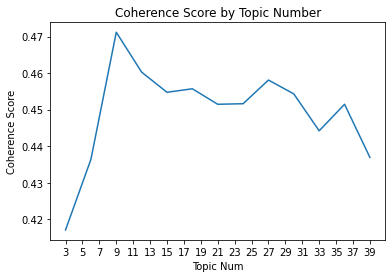

In [169]:
import matplotlib.pyplot as plt
scores = list(zip(topic_nums, coherence_scores))
plt.plot(topic_nums, coherence_scores)
plt.xticks(np.arange(3, 40,2))
plt.ylabel('Coherence Score')
plt.xlabel('Topic Num')
plt.title("Coherence Score by Topic Number")
plt.show()

In [214]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.85, min_df=2, max_features=2000)
tf = tf_vectorizer.fit_transform(data)
tf_feature_names = tf_vectorizer.get_feature_names()
lda = LatentDirichletAllocation(n_components=9,random_state=0).fit(tf)

C:\Users\maryx\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [171]:
get_topics(lda,9)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09
0,shall,customer,investing,patented,customer,asset,store,llc,propane
1,stock,master,securing,fda,solution,cash,customer,bank,presented
2,agreement,system,tax,clinical,system,north,brand,federal,profitability
3,common,energy,capital,drug,technology,tax,resulting,institute,vice
4,issue,producing,includes,headquarters,application,first,first,capital,office
5,date,ohio,could,past,data,statement,distribution,credit,holiday
6,people,equipment,functionality,medicaid,software,negatively,believe,rapidly,return
7,previously,cost,fee,device,support,separate,consumer,separate,approximately
8,director,facility,subject,treatment,proven,value,approximately,read,chief
9,exchange,garden,act,approval,net,includes,marketer,military,regulated


### Difference in document-topic vectors

In [215]:
X = tf_vectorizer.transform(netflix["coDescription"].tolist())
netflix_top = lda.transform(X)
netflix_top_df = pd.DataFrame(netflix_top).set_index(netflix["filingDate"])

0     0.320044
1     0.086204
2    -0.012440
3    -0.003216
4    -0.026677
5    -0.089333
6     0.096739
7     0.159221
8    -0.004736
9     0.071193
10    0.044994
11   -0.012463
12   -0.074672
13   -0.118126
14    0.054081
15    0.111513
16   -0.084884
17    0.018566
18   -0.083206
19   -0.026132
Name: 2008-02-28T00:42:30Z, dtype: float64

In [184]:
#compare 2012 with 2008 
netflix_top_df.iloc[-1] - netflix_top_df.iloc[0]

0   -0.013953
1    0.000202
2    0.000202
3   -0.001993
4   -0.090778
5    0.023481
6    0.032062
7    0.000202
8    0.050576
dtype: float64

- decrease in topic 1(?) ,5(software)
- increase in topic 6(finance), 7(retail), 9(legal?)

In [185]:
X = tf_vectorizer.transform(ge["coDescription"].tolist())
ge_top = lda.transform(X)
ge_top_df = pd.DataFrame(ge_top).set_index(ge["filingDate"])
ge_top_df

,0,1,2,3,4,5,6,7,8
filingDate,,,,,,,,,
2011-02-25T21:33:50Z,0.000047,0.498023,0.036266,0.070316,0.114108,0.007328,0.000047,0.112384,0.161482
2012-02-24T21:29:18Z,0.011215,0.533556,0.030604,0.075787,0.104087,0.015506,0.012698,0.135751,0.080796
2013-02-26T22:17:59Z,0.034429,0.550539,0.026982,0.065935,0.115461,0.016585,0.027572,0.141499,0.020998
2014-02-27T21:55:58Z,0.016560,0.508674,0.034713,0.068372,0.111263,0.022444,0.067732,0.169345,0.000897


In [186]:
# compare 2014 to 2011 
ge_top_df.iloc[-1] - ge_top_df.iloc[0]

0    0.016514
1    0.010651
2   -0.001553
3   -0.001944
4   -0.002845
5    0.015117
6    0.067685
7    0.056961
8   -0.160586
dtype: float64

- decrease in topic 9(legal?)
- increase in topic 7(retail), 8(finance,banking)

### LSA

In [188]:
from sklearn.decomposition import TruncatedSVD
vectorizer = TfidfVectorizer(max_df=0.85, max_features=2000) 
X = vectorizer.fit_transform(data)
svd = TruncatedSVD(n_components=20)
svd_model = pd.DataFrame(svd.fit_transform(X))

In [204]:
get_topics(svd,20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19,Topic # 20
0,customer,store,store,patient,loan,oil,ethanol,gas,president,loan,food,mineral,investment,customer,home,item,item,aircraft,food,customer
1,store,customer,merchandise,clinical,bank,gas,corn,oil,vice,share,brand,mining,fund,merger,cannabis,registrant,client,system,cannabis,aircraft
2,system,merchandise,loan,fda,patient,ethanol,grain,software,officer,mineral,client,exploration,adviser,client,aircraft,estate,segment,franchise,restaurant,vehicle
3,fiscal,brand,share,drug,fda,natural,distiller,exploration,chief,cannabis,investment,project,client,target,client,investment,solution,restaurant,store,partnership
4,share,apparel,stock,trial,clinical,production,software,client,served,bank,consumer,claim,portfolio,transaction,construction,property,brand,food,solution,property
5,brand,retail,brand,cancer,mortgage,exploration,client,property,executive,agreement,restaurant,property,advisor,opportunity,item,real,statement,aviation,franchise,cancer
6,technology,retailer,common,store,credit,water,gallon,natural,client,exploration,beverage,mine,cannabis,loan,segment,restaurant,registrant,entertainment,franchisees,investment
7,agreement,fiscal,investment,study,trial,drilling,data,mineral,care,mining,fund,gold,store,vehicle,land,statement,loan,flight,beverage,exploration
8,stock,footwear,apparel,treatment,drug,grain,solution,data,senior,stock,ingredient,ethanol,capital,security,contract,entertainment,mineral,franchisees,coffee,drug
9,segment,assortment,retail,medical,estate,mineral,fuel,drilling,food,home,segment,statement,power,registrant,building,device,mining,client,ingredient,partner


### Difference in document-topic vectors

In [205]:
X = vectorizer.transform(netflix["coDescription"].tolist())
netflix_top = svd.transform(X)
netflix_top_df = pd.DataFrame(netflix_top).set_index(netflix["filingDate"])
netflix_top_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
filingDate,,,,,,,,,,,,,,,,,,,,
2008-02-28T00:42:30Z,0.320044,0.086204,-0.012440,-0.003216,-0.026677,-0.089333,0.096739,0.159221,-0.004736,0.071193,0.044994,-0.012463,-0.074672,-0.118126,0.054081,0.111513,-0.084884,0.018566,-0.083206,-0.026132
2009-02-25T21:22:45Z,0.298948,0.057729,-0.011823,0.004651,-0.036582,-0.081763,0.092373,0.143640,0.000248,0.073183,0.056701,-0.020148,-0.086579,-0.124094,0.051609,0.127711,-0.076010,0.050323,-0.103739,-0.025288
2010-02-22T19:09:32Z,0.311064,0.075021,-0.032046,-0.002118,-0.028246,-0.084266,0.093036,0.134595,-0.001380,0.065354,0.065963,-0.032756,-0.090979,-0.121018,0.026939,0.108635,-0.055247,0.042715,-0.098052,-0.016218
2011-02-18T19:42:40Z,0.235158,0.009781,-0.028781,0.007047,-0.037482,-0.057171,0.063465,0.094612,0.028675,0.047091,0.070260,-0.003777,-0.080929,-0.097285,0.004142,0.129168,-0.046366,0.050336,-0.093099,-0.012742
2012-02-10T22:29:24Z,0.298476,0.011272,-0.029652,-0.010918,-0.043767,-0.058476,0.064649,0.094965,0.017139,0.023829,0.076288,0.002456,-0.122445,-0.125573,0.020715,0.137674,-0.034547,0.038780,-0.104771,0.000587


In [206]:
#compare 2012 with 2008 
netflix_top_df.iloc[-1] - netflix_top_df.iloc[0]

0    -0.021567
1    -0.074932
2    -0.017211
3    -0.007703
4    -0.017090
5     0.030857
6    -0.032090
7    -0.064255
8     0.021875
9    -0.047364
10    0.031294
11    0.014919
12   -0.047773
13   -0.007448
14   -0.033366
15    0.026161
16    0.050337
17    0.020214
18   -0.021565
19    0.026719
dtype: float64

- decrease in topic 2(retail/distribution) ,8(software, mining), 13(investment), 10(loan, real estate, commodities)
- increase in topic 6(natural resources/exploration), 11(food, marketing), 17(?)

In [207]:
X = vectorizer.transform(ge["coDescription"].tolist())
ge_top = svd.transform(X)
ge_top_df = pd.DataFrame(ge_top).set_index(ge["filingDate"])
ge_top_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
filingDate,,,,,,,,,,,,,,,,,,,,
2011-02-25T21:33:50Z,0.481511,-0.076468,-0.115548,-0.131421,0.092017,0.121786,-0.050700,0.006487,0.017142,-0.038494,-0.029542,-0.007060,0.067528,-0.045134,0.165391,0.109140,0.056954,0.147321,-0.091883,0.030465
2012-02-24T21:29:18Z,0.486454,-0.092141,-0.116039,-0.148235,0.097716,0.161368,-0.072456,0.010697,0.022214,-0.066274,-0.057195,-0.039949,0.078188,0.002967,0.170599,0.089286,0.100887,0.111349,-0.077397,0.033640
2013-02-26T22:17:59Z,0.482642,-0.097719,-0.111440,-0.152740,0.077203,0.167533,-0.082711,0.002903,0.017465,-0.070464,-0.061800,-0.048341,0.061807,0.022016,0.178503,0.087291,0.126216,0.086923,-0.066592,0.032776
2014-02-27T21:55:58Z,0.490679,-0.096178,-0.083033,-0.154771,0.116424,0.146756,-0.079415,-0.001103,0.018648,-0.069932,-0.041976,-0.036546,0.045302,0.024818,0.146687,0.087582,0.124961,0.053977,-0.055363,0.040454


In [208]:
# compare 2014 to 2011 
ge_top_df.iloc[-1] - ge_top_df.iloc[0]

0     0.009168
1    -0.019710
2     0.032514
3    -0.023350
4     0.024407
5     0.024970
6    -0.028716
7    -0.007591
8     0.001506
9    -0.031439
10   -0.012434
11   -0.029486
12   -0.022226
13    0.069952
14   -0.018704
15   -0.021558
16    0.068007
17   -0.093344
18    0.036520
19    0.009989
dtype: float64

- decrease in topic 10(loan, real estate, commodities), 12(comodities?),18(aerospace)
- increase in topic 3(loan/banking), 14(acquisition), 17(?)

## Summary
#### NMD Results

__Netflix__
- decrease in topic 2(retail/store), 15(real estate/land)
- increase in topic 10 (finances), 11 (branding?)

Note : interesting slight decrease in topic 8(software)

__GE__
- decrease in topic 15(real estate/land), 18(aerospace, vehicles)
- increase in topic 5(loan/bank), 6(energy/gas), 16 (financial/analysis)

#### LDA Results

__Netflix__
- decrease in topic 1(?) ,5(software)
- increase in topic 6(finance), 7(retail), 9(legal?)

__GE__
- decrease in topic 9(legal?)
- increase in topic 7(retail), 8(finance,banking)

#### LSA Results

__Netflix__
- decrease in topic 2(retail/distribution) ,8(software, mining), 13(investment), 10(loan, real estate, commodities)
- increase in topic 6(natural resources/exploration), 11(food, marketing), 17(?)

__GE__
- decrease in topic 10(loan, real estate, commodities), 12(comodities?),18(aerospace)
- increase in topic 3(loan/banking), 14(acquisition), 17(?)

##### LSA and NMF are similar but LSA's topics are easier to interpret